# Step 2

This is just some more complex experiments of the same nature though. To show the scalability of the previously used methods

In [1]:
from sp_sims.detectors.pearsonneyman import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import datetime
import argparse
from sklearn.metrics import roc_curve
from math import factorial
import sp_sims
from scipy.linalg import expm
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
from sp_sims.estimators.algos import *
from IPython.display import clear_output
from sp_sims.sanitycheck.truebirthdeath import *
import sp_sims.utils.utils
import random
from itertools import product,islice
#from tqdm.notebook import tqdm

from tqdm import tqdm
from time import sleep
import time

In [2]:

importlib.reload(sp_sims.statistics.statistics)
importlib.reload(sp_sims.detectors.pearsonneyman)


<module 'sp_sims.detectors.pearsonneyman' from '/Users/rac716/Research/RL_RateOptimization/sp_sims/detectors/pearsonneyman.py'>

In [3]:
# We may change args here:
class Args:
  xres = 100
  #length = 10000# Number of transitions in continuous chain 
  state_limit = 1#Inclusive
  init_state = 0
  num_samples = 5
  detection_guesses =1000
args = Args()

In [4]:
def prob_of_path(path,  p0,p1):
    # Take two possible hypothesis
    num = 1
    denum = 1
    for i in range(len(path)-1):
        from_state = path[i]
        to_state = path[i+1]
        num  *= p0[from_state,to_state]
        denum *= p1[from_state,to_state]
    # Return the least preferred one
    return num if denum > num else denum
def batched(iterable, n):
    "Batch data into tuples of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while (batch := tuple(islice(it, n))):
        yield batch

## Error Calculation

Basically Calculate:
$$
\begin{align}
P(\epsilon| \Delta) &= \mathbb{E}\left[P(\epsilon|p,\Delta)\right]\\
    &= \mathbb{E}_{\rho\sim P(\rho|\Delta)}\left[\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}\right]
\end{align}
$$
Where $P^{(j)}$ indicates probability of path of wrong hypothesis

In [5]:

# We want to calculate the average error probability for all paths
# We shouldn't be needing paths
from itertools import product

np.random.seed(0)
#np.random.seed(int(time.time()))
#num_steps = args.length
#num_states = args.state_limit+1
num_states = args.state_limit+1

samp_rates = np.logspace(-3,5,args.xres, base=2)

if (True):
    ## Two Variable Only
    #rates0 = {"lam": 4/10,"mu":12/10}
    ##rates1 = {"lam": 100/10,"mu":122/10}
    rates0 = {"lam": 4/10,  "mu":12/10}
    #rates1 = {"lam": 100/10,"mu":122/10}
    #rates1 = {"lam": 168/10,"mu":248/10}
    rates1 = {"lam": 2/15,"mu":49/10}
    Q0 = generate_true_gmatrix(rates0, args.state_limit)
    Q1 = generate_true_gmatrix(rates1, args.state_limit)
else:
    Q0 = random_bd_gmatrix(args.state_limit)
    Q1 = random_bd_gmatrix(args.state_limit)

rates = [rates0,rates1]
matrices = [Q0,Q1]
np.set_printoptions(precision=3)
print("Q0:\n",Q0)
print("Q1:\n",Q1)
print('LamDiff = {} MuDiff ={}'.format(Q0[0,0]-Q1[0,0],Q0[1,1]-Q1[1,1]))

# For Two States
#tgm0 = np.array([[-rates0['lam'],rates0['lam']],[rates0['mu'],-rates0['mu']]])
#tgm1 = np.array([[-rates1['lam'],rates1['lam']],[rates1['mu'],-rates1['mu']]])

hts, sts = ([],[])
last_times  = []
true_values = np.random.choice(2,args.detection_guesses)
# Generate The Tapes
for i in range(args.detection_guesses):
    #roe = RaceOfExponentials(args.length,rates[true_values[i]],state_limit=args.state_limit)
    roe = RaceOfExponentials(args.num_samples*(1/samp_rates[0]), rates[true_values[i]],max_state=1)# TODO Remove that hardcoded 1
    #roe = GeneralEmbeddedMarkC(args.length,matrices[true_values[i]])
    holdTimes_tape, state_tape = roe.generate_history(args.init_state)
    hts.append(holdTimes_tape)
    sts.append(state_tape)
    last_times.append(np.cumsum(holdTimes_tape)[-1])

# Preparation of True Probabilities
true_p0s = []
true_p1s = []
fixed_guesses = np.ones((len(samp_rates), args.detection_guesses))
# Crete all the *known* probability functions.
for srIdx, cur_samp_rate in enumerate(samp_rates):
    true_p0s.append(expm(Q0*(1/cur_samp_rate)))
    true_p1s.append(expm(Q1*(1/cur_samp_rate)))



Q0:
 [[-0.4  0.4]
 [ 1.2 -1.2]]
Q1:
 [[-0.133  0.133]
 [ 4.9   -4.9  ]]
LamDiff = -0.2666666666666667 MuDiff =3.7


## Theoretical Error

In [6]:
# Generate
# TODO decrease memory consumption by only using iterators
num_steps = args.num_samples
states = np.arange(num_states)
probs = []
tot_calcs = 0
if(num_steps < 6 or args.state_limit >= 7): # Will crash memory
    paths = np.array(list(product(states, repeat=num_steps-1)))
    paths = np.concatenate([np.repeat([[0]],repeats=paths.shape[0], axis=0), paths], axis=1)
    # Sum them up and that should be your probability 
    tot_calcs = paths.shape[0]
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        #probs.append(np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))
        probs.append((1/2)*np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))
else:
    # For Each Sampling rate
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        #probs.append(np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))
        paths = product(states, repeat=num_steps-1)
        prob = 0
        for batch in batched(paths,2**8):# Keep it at batches of 2**8 
            batch = np.array(batch)
            batched_paths = np.concatenate([np.repeat([[0]],repeats=batch.shape[0], axis=0), batch], axis=1)
            prob+= np.sum(np.apply_along_axis(prob_of_path, 1, batched_paths, true_p0s[srIdx],true_p1s[srIdx]))
            tot_calcs += batch.shape[[0]]
        prob *= 1/2
        probs.append(prob)
print("Total Permutations: ",tot_calcs)
print("Permutations",paths)

Total Permutations:  16
Permutations [[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 1 1 1]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [0 1 0 1 0]
 [0 1 0 1 1]
 [0 1 1 0 0]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [0 1 1 1 1]]


## Numerical Error

In [39]:

# Redo the testing experiments
np.random.seed(0)
last_times  = []

base_samp_rate = samp_rates[-1]

#for i in range(args.detection_guesses):
#    #roe = RaceOfExponentials(args.length,rates[true_values[i]],state_limit=args.state_limit)
#    roe = GeneralEmbeddedMarkC(args.length,matrices[true_values[i]])
#    holdTimes_tape, state_tape = roe.generate_history(args.init_state)
#    hts.append(holdTimes_tape); sts.append(state_tape)
#    last_times.append(np.cumsum(holdTimes_tape)[-1])

# Go Over the Detection Guesses
guesses = np.zeros((len(samp_rates), args.detection_guesses))
min_length = np.inf
for i in tqdm(np.arange(args.detection_guesses)):
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        # Fetch Values for Current Rate
        true_p0 = true_p0s[srIdx]
        true_p1 = true_p1s[srIdx]
        
        
        #LG: How many of the baseline intervals fit into the slow rate interval
        decimateInterval = int(base_samp_rate/cur_samp_rate)

        ##tmpSampTapel = quick_sample(cur_samp_rate, sts[i],hts[i])
        ##limited_sampled_tape = tmpSampTapel[0:args.num_samples]
        
        tmpSampTape, replicas = quick_sample_budget(cur_samp_rate, sts[i],hts[i], budget= args.num_samples)
        # Limit the Sample
        ############################################
        # Option 2 with limited number of samples ##
        ############################################

        ##meep = take_a_guess(limited_sampled_tape,true_p0, true_p1)
        moop = multiplicity_guess(tmpSampTape,replicas, true_p0, true_p1)
        guesses[srIdx, i] = moop

        #if meep != moop:
            #print('Ooops')
            #exit(-1)
        #assert meep == moop

num_negs = np.sum(true_values == 0)#TN + FP
num_pos = np.sum(true_values == 1)#TP + FN
#print("Min Length reached is ", min_length)

fprs,fnrs = ([],[])
t1s,t2s = ([],[])
hit_rates = []

# Calculate Probability of Error
for srIdx, cur_samp_rate in enumerate(samp_rates):
    guess = guesses[srIdx]
    hits_index = (true_values == guess)
    neg_guess = guess == 0
    pos_guess = guess == 1
    tp = (true_values[hits_index] == 1).sum()
    tn = (true_values[hits_index] == 0).sum()

    #t1s.append((num_pos-tp)/tn)/(0.5)
    t1s.append(((num_negs-tn)/num_negs)*(0.5))
    t2s.append(((num_pos-tp)/num_pos)*(0.5))
    #t2s.append((num_negs-tn))

    # False Positive and Negative Rates
    fprs.append((num_negs-tn)/(num_negs))
    fnrs.append((num_pos-tp)/(num_pos))# Type 2 Error
    num_hits = (true_values == guess).sum()
    hit_rates.append(num_hits/args.detection_guesses)
#fprs = np.array(fprs)
#fnrs = np.array(fnrs)
#tot_error = fprs+ fnrs
t1s = np.array(t1s)
t2s = np.array(t2s)
tot_error = t1s + t2s


100%|██████████| 1000/1000 [00:01<00:00, 833.87it/s]


In [33]:
# Collector 
# Inside the collector we collect stuff ay ?

#gtot_error = {}
#gtot_probs = {}

gtot_error['8'] = tot_error
gtot_probs['8'] = probs

In [85]:
gtot_error['51.2'] = pickle_load()
gtot_probs['51.2'] = probs

dict_keys(['0.1', '0.2', '0.4', '0.8', '1.6', '3.2', '6.4', '12.8', '25.6'])


In [26]:
# Lets try to load up the replay buffer to see how 

dict_keys(['2'])

Minimum Error is obtained at 0.125
This show that the summation of both errors is closer to monotonicity than having peaks.


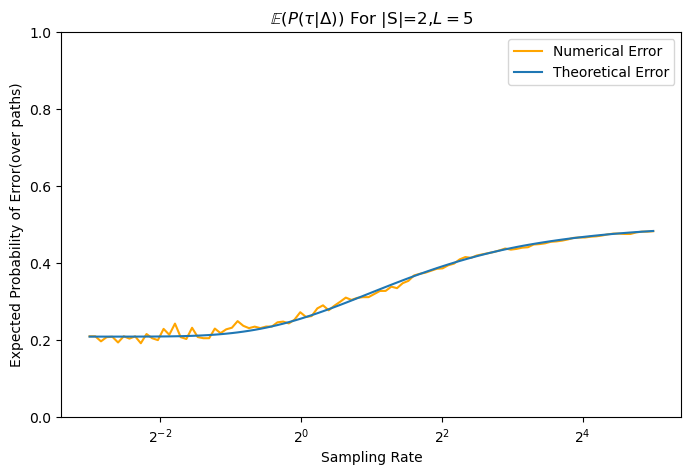

In [40]:
#ratess = {"lam0":4/10,"mu0":12/10,"lam1":100/10,"mu1":122/10}
#for k,v in ratess.items():
#    plt.axvline(x=v,label=k,c=np.random.rand(3,))
multiple = False

fig = plt.figure(figsize=(8,5))
plt.tight_layout()
if(not multiple):
    plt.plot(samp_rates, tot_error, color='orange', label='Numerical Error')
    plt.plot(samp_rates, probs, label='Theoretical Error')
    plt.title('$\mathbb{E}(P(\\tau | \Delta ))$'+f' For |S|={args.state_limit+1},$L={args.num_samples}$')
    print('Minimum Error is obtained at {}'.format(samp_rates[np.argmin(probs)]))
    plt.xscale('log', base=2)
    plt.legend()
    plt.xlabel('Sampling Rate')
    plt.ylabel('Expected Probability of Error(over paths)')
    plt.ylim(0,1)
    print('This show that the summation of both errors is closer to monotonicity than having peaks.')
    plt.show()
else:
    i=0.4
    for i,(k,e) in enumerate(gtot_error.items()):
        color = plt.get_cmap()(i/len(gtot_error))[:-1]
        #color = i*np.array([0.3,0.7,0.9])
        plt.plot(samp_rates, e, label='$E_n, |S| $= '+k,c=color,alpha=0.3)
        plt.plot(samp_rates, gtot_probs[k],c=color)
        i += 0.1
    plt.title('Varying State-Length $\mathbb{E}(P(\\tau | \Delta )), |L| = 8$ ')
    plt.xscale('log', base=2)
    plt.legend(prop={'size':8})
    plt.xlabel('Sampling Rate')
    plt.ylabel('Expected Probability of Error(over paths)')
    plt.ylim(0,0.6)
    plt.savefig('./Images/BDL8VaryingStates/figure.png',dpi=300)
    plt.show()

In [36]:
import pickle
with open('./Images/BDL8VaryingStates/num_error.pkl','wb') as outp:
    pickle.dump(gtot_error,outp, pickle.HIGHEST_PROTOCOL)
with open('./Images/BDL8VaryingStates/theo_error.pkl','wb') as outp:
    pickle.dump(gtot_probs,outp, pickle.HIGHEST_PROTOCOL)
with open('./Images/BDL8VaryingStates/args.pkl','wb') as outp:
    pickle.dump(args,outp, pickle.HIGHEST_PROTOCOL)
plt.clf()

<Figure size 640x480 with 0 Axes>

# RL Oracle for Fairer Comparison

We just want to verify our Q function now:

In [9]:
from sp_sims.learning.rl import RNNContinuousPolicy, Critic,ReplayBuffer
from torch import nn
import torch
import os.path
import numpy as np
import pickle
from sp_sims.detectors.pearsonneyman import *
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
import torch.optim as optim


In [10]:
# Create the Datasets
# We may change args here:
class Args2:
  xres = 100
  length = 5000# Number of transitions in continuous chain 
  state_limit = 1#Inclusive # DO NOT CHANGE, Architecture can't take it yet
  init_state = 0
  num_samples =5
  batch_size =128
  poptimizer_lr = 1e-4
  coptimizer_lr = 1e-4
  clipping_limit = 16 # Sampling rate no Bigger than this. 
  num_epochs = 100000
  num_replay_samples = 1 # How many batches do we sample at a time to learn 
# Data Class
class MetaState:
  states: list
  holding_times: list
  def __init__(self,states, holding_times):
    self.states = states
    self.holding_times = holding_times

args2 = Args2()

In [11]:
def get_errors(sampled_tapes, probs, true_hyps):
    # Clean it up 
    p0, p1 = probs
    # Take our guesses
    guesses = np.array([take_a_guess(tape, p0[i],p1[i]) for i,tape in enumerate(sampled_tapes)])
    errors = -1*np.array(true_hyps != guesses)
    return errors


def take_a_guess(tape, p0,p1):
    num = 0
    denum = 0
    for i in range(len(tape)-1):
        from_state = tape[i]
        to_state = tape[i+1]
        num += np.log(p0[from_state,to_state])
        denum += np.log(p1[from_state,to_state])
    return 0 if num > denum else 1


In [12]:
# Start Working on the Model
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from tqdm.auto import tqdm

if torch.backends.mps.is_available():
    print("Activating Apple Metal")
    device = torch.device("mps")
else:
    device = torch.device("cpu")

class PolicyLoss(nn.Module):
    def __init__(self):
        super(PolicyLoss, self).__init__()

    def forward(self, estimation):
        return torch.mean(estimation)

# TODO remove hard code 
policy = RNNContinuousPolicy(2*2,hidden_size=16).to(device)
critic = Critic(2*2, 1, 16).to(device)
poptimizer = optim.Adam(policy.parameters(), lr = args2.poptimizer_lr)
coptimizer = optim.Adam(critic.parameters(), lr = args2.coptimizer_lr)

# Open Replay Buffer File
existed = os.path.exists('./ReplayBuffer/buffer_len{}.pkl'.format(args2.num_samples))
buffer_file = open('./ReplayBuffer/buffer_len{}.pkl'.format(args2.num_samples),'rb')
rbuffer = ReplayBuffer(sampbudget=args2.num_samples)
if existed:
    print('Found Previous Buffer, Now Loading...')
    rbuffer.memory = pickle.load(buffer_file)
buffer_file.close()
buffer_file = open('./ReplayBuffer/new_buffer_len{}.pkl'.format(args2.num_samples),'wb')


#populate_replay_buffer(rbuffer,args2.batch_size)

# We have Enough Data to Start Sampling and Exploring With 
epochs = tqdm(range(args2.num_epochs),leave=True)
qvalue_loss = []
policyExpectedReward = []
val_srate = []
qlosses,plosses = [],[]
q_losscrit = nn.MSELoss()
p_losscrit = PolicyLoss()

for e in epochs:
    clear_output(wait=True)
    poptimizer.zero_grad()
    coptimizer.zero_grad()
    ########################################
    # Collect Data
    ########################################
    # This loop will generate paths with the existing policy 
    # Sample Transitions used for learnign
    states, actions, rewards = rbuffer.sample(128)
    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)

    # Get Rates
    y = rewards
    # Since We We are Doing Accuracy We have to create 
    ########################################
    # Update Networks
    ########################################
    # Calculate the Losses
    #loss_Q = (1/args2.batch_size)*torch.sum(torch.pow(critic(states, actions) - y,2))
    #loss_P = (1/args2.batch_size)*torch.sum(critic(states, policy(states)))
    loss_Q = q_losscrit(critic(states,actions), y)
    loss_P = p_losscrit(critic(states,policy(states)))

    # Learn 
    loss_Q.backward()
    loss_P.backward()
    poptimizer.step()
    coptimizer.step()

    qlosses.append(loss_Q.item())
    plosses.append(loss_P.item())

    # In this one particular case we have a single point that is global max so it would be
    # best to use optimized policy to do some exploration 
    qvalue_loss.append(loss_Q.item())
    policyExpectedReward.append(loss_P.item())

    # Validate with a known global min:
    validation_input = torch.tensor([[4/10,12/10,100/10,122/10]]).to(device)
    policy.eval()
    with torch.no_grad():
        val_srate.append(float(policy(validation_input).squeeze(-1).item()))
    policy.train()

    # Lets check performance 
    if e % 100 == 0:
        plt.clf()
        val = critic(states,actions).cpu().detach()
        plt.scatter(range(128), val, label='Estimation',s=8)
        plt.scatter(range(128), y.cpu(), label='Labels',s=8)
        plt.plot(range(128), np.abs(val-y.cpu()), label='Difference', color='red',alpha=0.2)
        plt.title('Performance Epoch '+str(e))
        plt.legend()
        plt.show()
    
    # Lets look at the weights acrooss the network 
    epoch_description = ""

    for name, param in critic.named_parameters():
        epoch_description += "Parameter {} norm is {:.3f}\n".format(name, torch.norm(param)**2)

    epoch_description += 'Val Samp Rate {}, Loss_Q {} and loss_P {}'.format(val_srate[-1], np.mean(qlosses), np.mean(plosses))

    epochs.set_description(epoch_description)

    ## Prep for Next Iteration
    # Keep On Adding More Stuff to buffer to learn from 
    #add_actions_to_buffer(rbuffer, states.cpu(), actions.cpu())

    # Don't over populate the buffer
    if np.random.choice([0,1],1,p=[0.15,0.85]) == 0:
        rbuffer.populate_replay_buffer(64, args.detection_guesses)
        pickle.dump(rbuffer, buffer_file, protocol=pickle.HIGHEST_PROTOCOL)
buffer_file.close()
    


OSError: [Errno 28] No space left on device

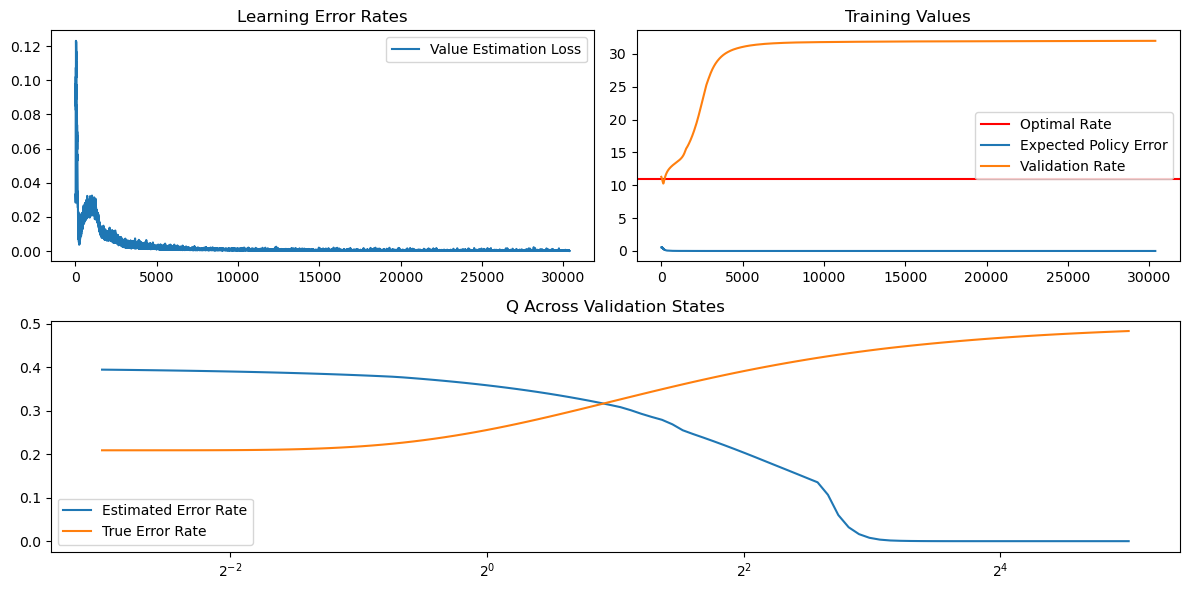

In [41]:

from datetime import datetime
now = datetime.now()
dtimestr = now.strftime("%m-%d-%y_%h:%m:%s")

critic.eval()
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2,2)

axs00 = fig.add_subplot(gs[0,0])
axs00.set_title('learning error rates')
axs00.plot(range(len(qvalue_loss)),qvalue_loss,label="value estimation loss")
axs00.legend()

axs01 = fig.add_subplot(gs[0,1])
axs01.set_title('training values')
axs01.axhline(y=11.03, label="optimal rate", color="red")
axs01.plot(range(len(policyexpectedreward)),policyexpectedreward,label="expected policy error")
axs01.plot(range(len(val_srate)),val_srate,label="validation rate")
axs01.legend()

critic_a = torch.tensor(samp_rates).view(-1,1).to(torch.float32).to(device)
#critic_s = torch.tensor([4/10,12/10,100/10,122/10]).repeat(len(samp_rates),1).to(torch.float32).to(device)
critic_s = torch.tensor([4/10,12/10,2/15,49/10]).repeat(len(samp_rates),1).to(torch.float32).to(device)
rates1 = {"lam": 2/15,"mu":49/10}
critic_y = critic(critic_s,critic_a).cpu().detach()

# printed estimated values 
axs10 = fig.add_subplot(gs[1,:])
axs10.set_title('q across validation states')
axs10.plot(samp_rates, critic_y, label='estimated error rate')
axs10.plot(samp_rates, probs, label='true error rate')
axs10.set_xscale('log', base=2)

#fig.delaxes(fig.axes[-1])
plt.tight_layout()
plt.legend()

plt.savefig('images/models/training_{}.png'.format(dtimestr))
plt.show()

In [15]:
buffer_file = open('./ReplayBuffer/new_buffer_len{}.pkl'.format(args2.num_samples),'wb')
pickle.dump(rbuffer, buffer_file, protocol=pickle.HIGHEST_PROTOCOL)
buffer_file.close()

294592

In [26]:
# Save the Models
details = {
    'QLosses' : qvalue_loss,
    'Policy Expected Reward' : policyExpectedReward,
    'PLosses' : plosses,
    'Validation Rate' : val_srate,
    'Sampling Rates' : samp_rates,
    'critic_y' : critic_y,
    'Validation Probs': probs
}

torch.save(critic.state_dict ,'Models/Critic_{}.pt'.format(dtimestr))
torch.save(policy.state_dict ,'Models/Policy_{}.pt'.format(dtimestr))
torch.save(details, 'Models/Details{}.bin'.format(dtimestr))